# HAR模型 - PyTorch实现

这个notebook实现了将TensorFlow版本的HART (Human Activity Recognition Transformer) 模型迁移到PyTorch的过程。

In [1]:
import subprocess
import os
import re
import numpy as np
import torch
import csv
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle
import random
import math
import logging
import shutil
import gc
import sys
import sklearn.manifold
import seaborn as sns
import argparse
import matplotlib.gridspec as gridspec
import __main__ as main
import torch.nn as nn
import torch.optim as optim

In [2]:
# 导入自定义模块
import model_pytorch as model
import utils_torch as utils

In [3]:
'''def pick_free_gpu(threshold_mb=2000):
    """选择一个空闲内存大于阈值的GPU"""
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits,noheader"],
        stdout=subprocess.PIPE,
        text=True
    )
    gpu_memory = [int(x) for x in result.stdout.strip().split('\n')]
    for idx, mem in enumerate(gpu_memory):
        if mem > threshold_mb:
            return str(idx)
    return None

# 选择GPU
gpu_id = pick_free_gpu()
if gpu_id is None:
    print("没有找到空闲GPU，使用CPU")
    device = torch.device("cpu")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
    device = torch.device(f"cuda:{0}")
    print(f"使用GPU:{gpu_id}")'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 设置随机种子
random_seed = 1
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
def is_interactive():
    """检查是否在交互式环境中运行"""
    return not hasattr(main, '__file__')

def get_layer_index_by_name(model, layername):
    """通过名称获取层的索引"""
    for name, child in model.named_modules():
        if name.endswith(layername):
            return name
    return None

## 设置超参数

In [5]:
# 设置默认超参数
architecture = "HART"  # MobileHART, HART
dataset_name = 'UCI'  # RealWorld, HHAR, UCI, SHL, MotionSense, COMBINED
data_config = "BALANCED"  # BALANCED, UNBALANCED
show_train_verbose = 1  # 显示训练详细信息: 0, 1
segment_size = 128  # 输入窗口大小
num_input_channels = 6  # 输入通道数
learning_rate = 5e-3  # 学习率
dropout_rate = 0.3  # 模型丢弃率
local_epoch = 50  # 本地周期
frame_length = 16  # 补丁大小
time_step = 16  # 步长
position_device = ''  # 位置/设备
# ['chest','forearm','head','shin','thigh','upperarm','waist']
# ['nexus4', 'lgwatch','s3', 's3mini','gear','samsungold']
token_based = False  # 是否基于token

# 模型超参数
batch_size = 256
projection_dim = 192
filter_attention_head = 4
# 调整HART的块数，添加或删除卷积核大小
# 每个卷积核长度对应一个HART块
conv_kernels = [3, 7, 15, 31, 31, 31]

In [6]:
# 输入形状和模型配置
input_shape = (segment_size, num_input_channels)
projection_half = projection_dim // 2
projection_quarter = projection_dim // 4
# 在初始化时打印这些值
print(f"projection_dim={projection_dim}, projection_half={projection_half}, projection_quarter={projection_quarter}")
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Transformer层的大小

R = projection_half // filter_attention_head
assert R * filter_attention_head == projection_half

segment_time = [x for x in range(0, segment_size - frame_length + time_step, time_step)]
assert R * filter_attention_head == projection_half
if position_device != '':
    assert dataset_name == "RealWorld" or dataset_name == "HHAR"

projection_dim=192, projection_half=96, projection_quarter=48


## 数据集和目录配置

In [7]:
if dataset_name == 'UCI':
    ACTIVITY_LABEL = ['Walking', 'Upstair', 'Downstair', 'Sitting', 'Standing', 'Lying']
elif dataset_name == "RealWorld":
    ACTIVITY_LABEL = ['Downstairs', 'Upstairs', 'Jumping', 'Lying', 'Running', 'Sitting', 'Standing', 'Walking']
elif dataset_name == "MotionSense":
    ACTIVITY_LABEL = ['Downstairs', 'Upstairs', 'Sitting', 'Standing', 'Walking', 'Jogging']
elif dataset_name == "HHAR":
    ACTIVITY_LABEL = ['Sitting', 'Standing', 'Walking', 'Upstair', 'Downstairs', 'Biking']
else:
    # SHL
    ACTIVITY_LABEL = ['Standing', 'Walking', 'Runing', 'Biking', 'Car', 'Bus', 'Train', 'Subway']

activity_count = len(ACTIVITY_LABEL)

# 定义主目录和文件路径
main_dir = './'  # 设置主目录为当前目录

architecture_type = str(architecture) + '_' + str(int(frame_length)) + 'frameLength_' + str(time_step) + 'TimeStep_' + str(projection_dim) + "ProjectionSize_" + str(learning_rate) + 'LR'
if token_based:
    architecture_type = architecture_type + "_tokenBased"
    
if position_device != '':
    architecture_type = architecture_type + "_PositionWise_" + str(position_device)

if local_epoch < 20:
    architecture_type = "Tests/" + str(architecture_type)

# 定义文件路径
filepath = main_dir + 'HART_Results/' + architecture_type + '/' + dataset_name + '/'
os.makedirs(filepath, exist_ok=True)

attention_path = filepath + "attentionImages/"
os.makedirs(attention_path, exist_ok=True)

best_model_path = filepath + 'bestModels/'
os.makedirs(best_model_path, exist_ok=True)

current_model_path = filepath + 'currentModels/'
os.makedirs(current_model_path, exist_ok=True)
if device.type == "mps":
    print("正在使用Mac的Metal性能着色器加速")
elif device.type == "cuda":
    print(f"可用GPU数量: {torch.cuda.device_count()}")
    print(f"当前使用的GPU: {torch.cuda.get_device_name(0)}")
else:
    print("正在使用CPU")

正在使用CPU


## 加载数据集

In [8]:
# 加载数据集
if dataset_name == "COMBINED":
    dataset_list = ["UCI", "RealWorld", "HHAR", "MotionSense", "SHL_128"]
    ACTIVITY_LABEL = ['Walk', 'Upstair', 'Downstair', 'Sit', 'Stand', 'Lay', 'Jump', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
    activity_count = len(ACTIVITY_LABEL)
    UCI = [0, 1, 2, 3, 4, 5]
    REALWORLD_CLIENT = [2, 1, 6, 5, 7, 3, 4, 0]
    HHAR = [3, 4, 0, 1, 2, 8]
    MotionSense = [2, 1, 3, 4, 0, 7]
    SHL = [4, 0, 7, 8, 9, 10, 11, 12]
    
    central_train_data = []
    central_train_label = []
    central_test_data = []
    central_test_label = []
    for dataset_name_iter in dataset_list:
        client_count = utils.return_client_by_dataset(dataset_name_iter) 
        loaded_dataset = utils.load_dataset_pytorch(dataset_name_iter, client_count, data_config, random_seed, os.path.join(main_dir, 'datasets/'))
        central_train_data.append(loaded_dataset.central_train_data.cpu().numpy())
        central_train_label.append(loaded_dataset.central_train_label.cpu().numpy())
        central_test_data.append(loaded_dataset.central_test_data.cpu().numpy())
        central_test_label.append(loaded_dataset.central_test_label.cpu().numpy())
        print(dataset_name_iter + " has class: " + str(np.unique(central_train_label[-1])))
        del loaded_dataset
    
    central_test_label_aligned = []
    central_train_label_aligned = []
    combined_aligned_data = central_test_data
    for index, dataset_name_iter in enumerate(dataset_list):
        if dataset_name_iter == 'UCI':
            central_train_label_aligned.append(central_train_label[index])
            central_test_label_aligned.append(central_test_label[index])
        elif dataset_name_iter == 'RealWorld':
            central_train_label_aligned.append(np.hstack([REALWORLD_CLIENT[label_index] for label_index in central_train_label[index]]))
            central_test_label_aligned.append(np.hstack([REALWORLD_CLIENT[label_index] for label_index in central_test_label[index]]))
        elif dataset_name_iter == 'HHAR':
            central_train_label_aligned.append(np.hstack([HHAR[label_index] for label_index in central_train_label[index]]))
            central_test_label_aligned.append(np.hstack([HHAR[label_index] for label_index in central_test_label[index]]))
        elif dataset_name_iter == 'MotionSense':
            central_train_label_aligned.append(np.hstack([MotionSense[label_index] for label_index in central_train_label[index]]))
            central_test_label_aligned.append(np.hstack([MotionSense[label_index] for label_index in central_test_label[index]]))
        else:
            central_train_label_aligned.append(np.hstack([SHL[label_index] for label_index in central_train_label[index]]))
            central_test_label_aligned.append(np.hstack([SHL[label_index] for label_index in central_test_label[index]]))
    central_train_data = np.vstack((central_train_data))
    central_test_data = np.vstack((central_test_data))
    central_train_label = np.hstack((central_train_label_aligned))
    central_test_label = np.hstack((central_test_label_aligned))
else:
    client_count = utils.return_client_by_dataset(dataset_name)
    dataset_loader = utils.load_dataset_pytorch(dataset_name, client_count, data_config, random_seed, main_dir+ 'datasets/')
    central_train_data = dataset_loader.central_train_data
    central_train_label = dataset_loader.central_train_label
    central_test_data = dataset_loader.central_test_data
    central_test_label = dataset_loader.central_test_label
    client_orientation_train = dataset_loader.client_orientation_train
    client_orientation_test = dataset_loader.client_orientation_test
    orientations_names = dataset_loader.orientations_names

In [9]:
# 如果在RealWorld或HHAR上使用指定位置/设备，我们移除一个并将其用作测试集，并将其他用于训练
if position_device != '' or dataset_name == 'UCI':
    if dataset_name == "RealWorld":
        total_data = np.vstack((central_train_data, central_test_data))
        total_label = np.hstack((central_train_label, central_test_label))
        try:
            total_orientation = np.hstack((np.hstack((client_orientation_train)), np.hstack((client_orientation_test))))
        except:
            total_orientation = np.hstack((np.hstack([x for x in client_orientation_train]), np.hstack([x for x in client_orientation_test])))
        total_index = list(range(total_orientation.shape[0]))
        test_data_index = np.where(total_orientation == orientations_names.index(position_device))[0]
        train_data_index = np.delete(total_index, test_data_index)
        
        central_train_data = total_data[train_data_index]
        central_test_data = total_data[test_data_index]
        
        central_train_label = total_label[train_data_index]
        central_test_label = total_label[test_data_index]
    elif dataset_name == "HHAR":
        total_data = np.vstack((central_train_data, central_test_data))
        total_label = np.hstack((central_train_label, central_test_label))
        try:
            total_orientation = np.hstack((np.hstack((client_orientation_train)), np.hstack((client_orientation_test))))
        except:
            total_orientation = np.hstack((np.hstack([x for x in client_orientation_train]), np.hstack([x for x in client_orientation_test])))
        total_index = list(range(total_orientation.shape[0]))
        # 0是nexus
        test_data_index = np.where(total_orientation == orientations_names.index(position_device))[0]
        train_data_index = np.delete(total_index, test_data_index)
        
        central_train_data = total_data[train_data_index]
        central_test_data = total_data[test_data_index]
        
        central_train_label = total_label[train_data_index]
        central_test_label = total_label[test_data_index]
    # 使用位置进行评估时，没有测试集，dev=test是相同的
    central_dev_data = central_test_data
    central_dev_label = central_test_label
else:
    # 使用70 10 20比例
    central_train_data, central_dev_data, central_train_label, central_dev_label = train_test_split(
        central_train_data, central_train_label, test_size=0.125, random_state=random_seed)

In [10]:
# 计算类权重
temp_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(central_train_label),
    y=central_train_label.ravel()
)
class_weights = {j: temp_weights[j] for j in range(len(temp_weights))}

In [11]:
# 创建PyTorch数据集和数据加载器
# 创建特征和标签的张量
train_features = torch.FloatTensor(central_train_data)
train_labels = torch.LongTensor(central_train_label)
dev_features = torch.FloatTensor(central_dev_data)
dev_labels = torch.LongTensor(central_dev_label)
test_features = torch.FloatTensor(central_test_data)
test_labels = torch.LongTensor(central_test_label)

# 创建数据集
train_dataset = utils.HARDataset(train_features, train_labels)
dev_dataset = utils.HARDataset(dev_features, dev_labels)
test_dataset = utils.HARDataset(test_features, test_labels)

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

## 创建和训练模型

In [12]:
# 创建模型
if architecture == "HART":
    model_classifier = model.HART(
        input_shape=input_shape,
        activity_count=activity_count,
        projection_dim=projection_dim,
        patch_size=frame_length,
        time_step=time_step,
        num_heads=3,
        filter_attention_head=filter_attention_head,
        conv_kernels=conv_kernels,
        dropout_rate=dropout_rate,
        use_tokens=token_based
    ).to(device)
else:
    model_classifier = model.MobileHART_XS(
        input_shape=input_shape,
        activity_count=activity_count
    ).to(device)

# 转换类权重为PyTorch张量
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in range(activity_count)]).to(device)

# 创建优化器和损失函数
optimizer = torch.optim.Adam(model_classifier.parameters(), lr=learning_rate)

# 添加学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, verbose=1
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

# 模型摘要
total_params = sum(p.numel() for p in model_classifier.parameters() if p.requires_grad)
print(f"模型总参数数量: {total_params}")

模型总参数数量: 333086


/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# 创建检查点路径
checkpoint_filepath = filepath + "bestValcheckpoint.pt"

# 训练模型
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_acc = 0.0

# 训练循环
start_time = time.time()
for epoch in range(local_epoch):
    # 训练阶段
    model_classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model_classifier(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        loss.backward()

        # 添加梯度裁剪
        torch.nn.utils.clip_grad_norm_(model_classifier.parameters(), max_norm=1.0)

        optimizer.step()
        
        # 记录损失和准确率
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
    
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    
    # 验证阶段
    model_classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in dev_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model_classifier(inputs)
            loss = criterion(outputs, targets)
            
            # 记录损失和准确率
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    # 打印进度
    if show_train_verbose == 1:
        print(f'Epoch {epoch+1}/{local_epoch} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_classifier.state_dict(), checkpoint_filepath)
        print(f'保存最佳模型，验证准确率: {val_acc:.4f}')

    scheduler.step(val_acc)
end_time = time.time() - start_time
print(f"训练时间: {end_time:.2f}秒")

# 保存当前模型
torch.save(model_classifier.state_dict(), filepath + 'bestTrain.pt')

Epoch 1/50 - Train Loss: 1.5866, Train Acc: 0.4914, Val Loss: 1.4933, Val Acc: 0.6240
保存最佳模型，验证准确率: 0.6240
Epoch 2/50 - Train Loss: 1.4615, Train Acc: 0.6540, Val Loss: 1.4235, Val Acc: 0.6875
保存最佳模型，验证准确率: 0.6875
Epoch 3/50 - Train Loss: 1.3912, Train Acc: 0.7300, Val Loss: 1.4040, Val Acc: 0.7160
保存最佳模型，验证准确率: 0.7160
Epoch 4/50 - Train Loss: 1.3634, Train Acc: 0.7599, Val Loss: 1.3600, Val Acc: 0.7564
保存最佳模型，验证准确率: 0.7564
Epoch 5/50 - Train Loss: 1.3291, Train Acc: 0.7952, Val Loss: 1.3497, Val Acc: 0.7716
保存最佳模型，验证准确率: 0.7716
Epoch 6/50 - Train Loss: 1.3138, Train Acc: 0.8107, Val Loss: 1.3362, Val Acc: 0.7855
保存最佳模型，验证准确率: 0.7855
Epoch 7/50 - Train Loss: 1.3110, Train Acc: 0.8123, Val Loss: 1.3314, Val Acc: 0.7862
保存最佳模型，验证准确率: 0.7862
Epoch 8/50 - Train Loss: 1.3209, Train Acc: 0.8030, Val Loss: 1.3523, Val Acc: 0.7587
Epoch 9/50 - Train Loss: 1.3066, Train Acc: 0.8179, Val Loss: 1.3508, Val Acc: 0.7604
Epoch 10/50 - Train Loss: 1.2864, Train Acc: 0.8375, Val Loss: 1.3239, Val Acc:

## 模型评估与分析

In [14]:
# 加载最佳模型
model_classifier.load_state_dict(torch.load(checkpoint_filepath))

# 测试阶段
model_classifier.eval()
test_correct = 0
test_total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 前向传播
        outputs = model_classifier(inputs)
        
        # 记录准确率
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()
        
        # 保存预测和真实标签
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# 计算测试准确率
test_acc = test_correct / test_total
print(f"测试准确率: {test_acc * 100:.2f}%")

测试准确率: 86.53%


In [15]:
# 保存历史数据
with open(filepath + 'history.pkl', 'wb') as f:
    pickle.dump(history, f)

# 计算F1分数
weight_val_f1 = f1_score(all_targets, all_preds, average='weighted')
micro_val_f1 = f1_score(all_targets, all_preds, average='micro')
macro_val_f1 = f1_score(all_targets, all_preds, average='macro')

# 保存模型统计信息
model_statistics = {
    "Results on server model on ALL testsets": '',
    "\nTrain:": utils.round_number(max(history['train_accuracy'])),
    "\nValidation:": utils.round_number(max(history['val_accuracy'])),
    "\nTest weighted f1:": utils.round_number(weight_val_f1),
    "\nTest micro f1:": utils.round_number(micro_val_f1),
    "\nTest macro f1:": utils.round_number(macro_val_f1),
}    
with open(filepath + 'GlobalACC.csv', 'w') as f:
    w = csv.writer(f)
    w.writerows(model_statistics.items())

## 提取特征嵌入和t-SNE可视化

In [16]:
# 创建一个获取中间层输出的函数
def get_intermediate_output(model, layer_name):
    # 定义前向传递钩子
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output
        return hook
    
    # 找到目标层并注册钩子
    for name, module in model.named_modules():
        if "mlp_head.0" in name:  # 获取mlp_head的第一层输入，即特征提取后的表示
            module.register_forward_hook(get_activation(layer_name))
            break
    
    return activation

# 获取中间层的表示
activation_dict = get_intermediate_output(model_classifier, "features")

# 提取嵌入
embeddings = []
all_targets_list = []

with torch.no_grad():
    model_classifier.eval()
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        # 前向传播，触发钩子
        model_classifier(inputs)
        # 获取激活值
        if "features" in activation_dict:
            feature_vector = activation_dict["features"].cpu().numpy()
            embeddings.append(feature_vector)
            all_targets_list.extend(targets.numpy())

# 将所有批次的嵌入堆叠在一起
embeddings = np.vstack(embeddings)

# t-SNE可视化
perplexity = min(30.0, embeddings.shape[0] - 1)  # 确保perplexity小于样本数
tsne_model = sklearn.manifold.TSNE(perplexity=perplexity, verbose=show_train_verbose, random_state=random_seed)
tsne_projections = tsne_model.fit_transform(embeddings)

# 准备标签
labels_argmax = np.array(all_targets)
unique_labels = np.unique(labels_argmax)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2947 samples in 0.001s...
[t-SNE] Computed neighbors for 2947 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2947
[t-SNE] Computed conditional probabilities for sample 2000 / 2947
[t-SNE] Computed conditional probabilities for sample 2947 / 2947
[t-SNE] Mean sigma: 15.131637
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.804375
[t-SNE] KL divergence after 1000 iterations: 0.690145


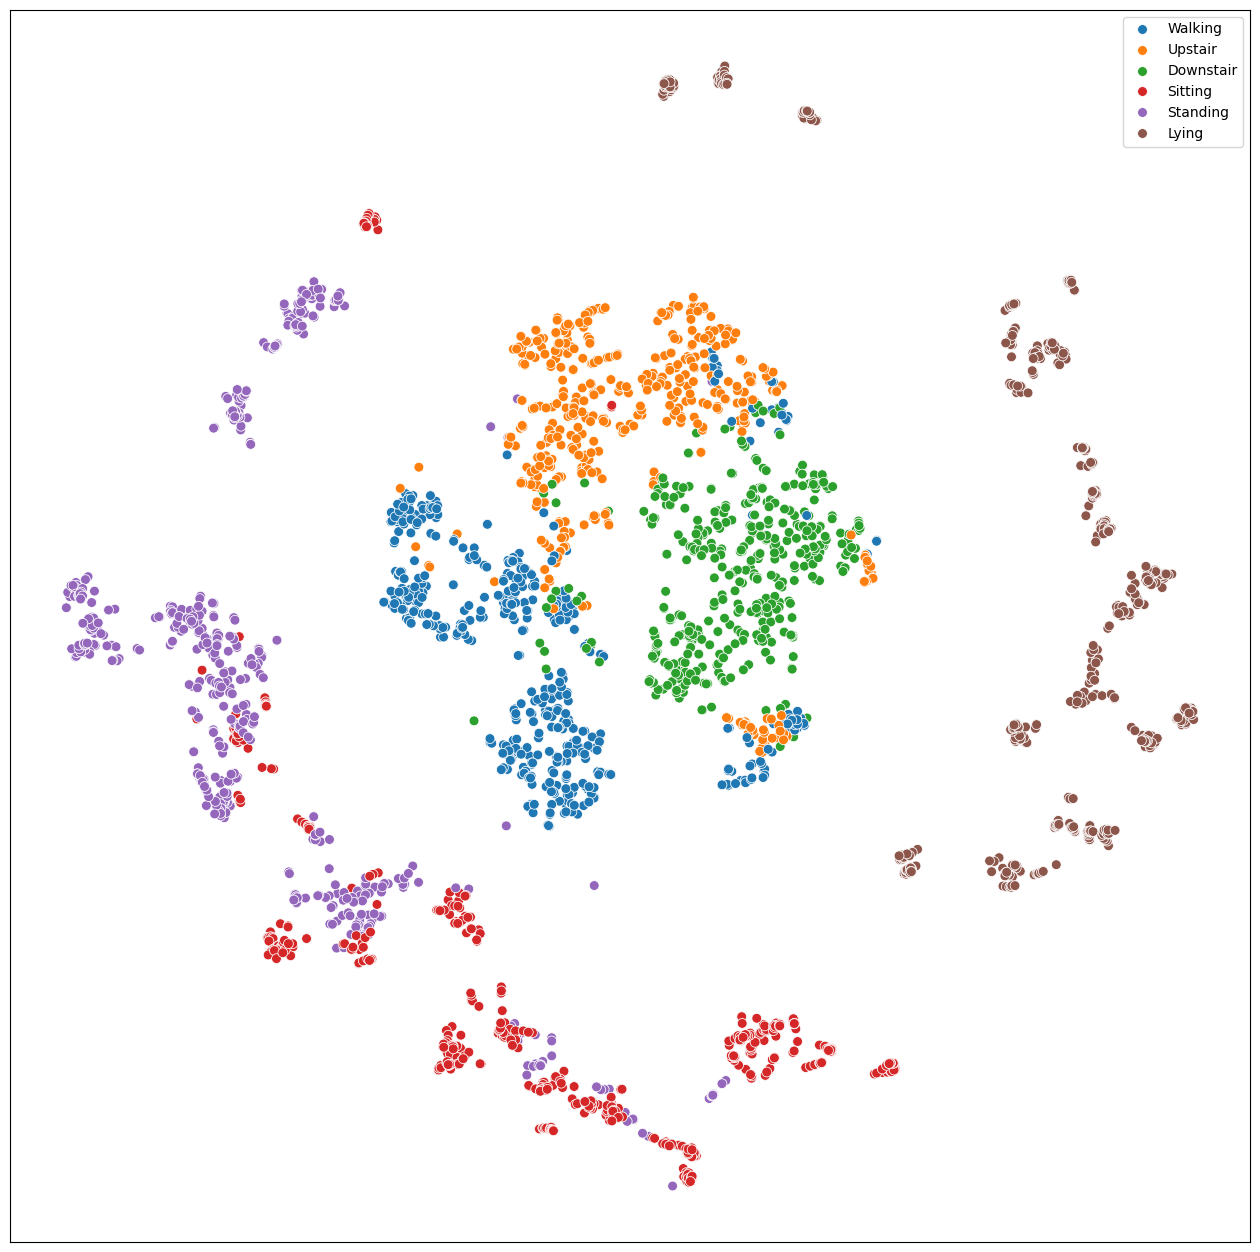

In [17]:
# 绘制t-SNE图
if (dataset_name == 'RealWorld' or dataset_name == 'HHAR') and position_device == '':
    utils.project_tsne_with_position(dataset_name, architecture + "_TSNE_Embeds", filepath, ACTIVITY_LABEL,
                                   labels_argmax, orientations_names, client_orientation_test,
                                   tsne_projections, unique_labels)
else:
    utils.project_tsne(architecture + "_TSNE_Embeds", filepath, ACTIVITY_LABEL,
                     labels_argmax, tsne_projections, unique_labels)

## 绘制混淆矩阵和注意力可视化

/var/folders/fr/14dg9d1n4vx9sqmyh_9pqm3h0000gn/T/ipykernel_31489/1885234615.py:10: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.
  plt.savefig(filepath + 'HeatMap.png')
/var/folders/fr/14dg9d1n4vx9sqmyh_9pqm3h0000gn/T/ipykernel_31489/1885234615.py:10: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) Arial.
  plt.savefig(filepath + 'HeatMap.png')
/var/folders/fr/14dg9d1n4vx9sqmyh_9pqm3h0000gn/T/ipykernel_31489/1885234615.py:10: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Arial.
  plt.savefig(filepath + 'HeatMap.png')
/var/folders/fr/14dg9d1n4vx9sqmyh_9pqm3h0000gn/T/ipykernel_31489/1885234615.py:10: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Arial.
  plt.savefig(filepath + 'HeatMap.png')
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) A

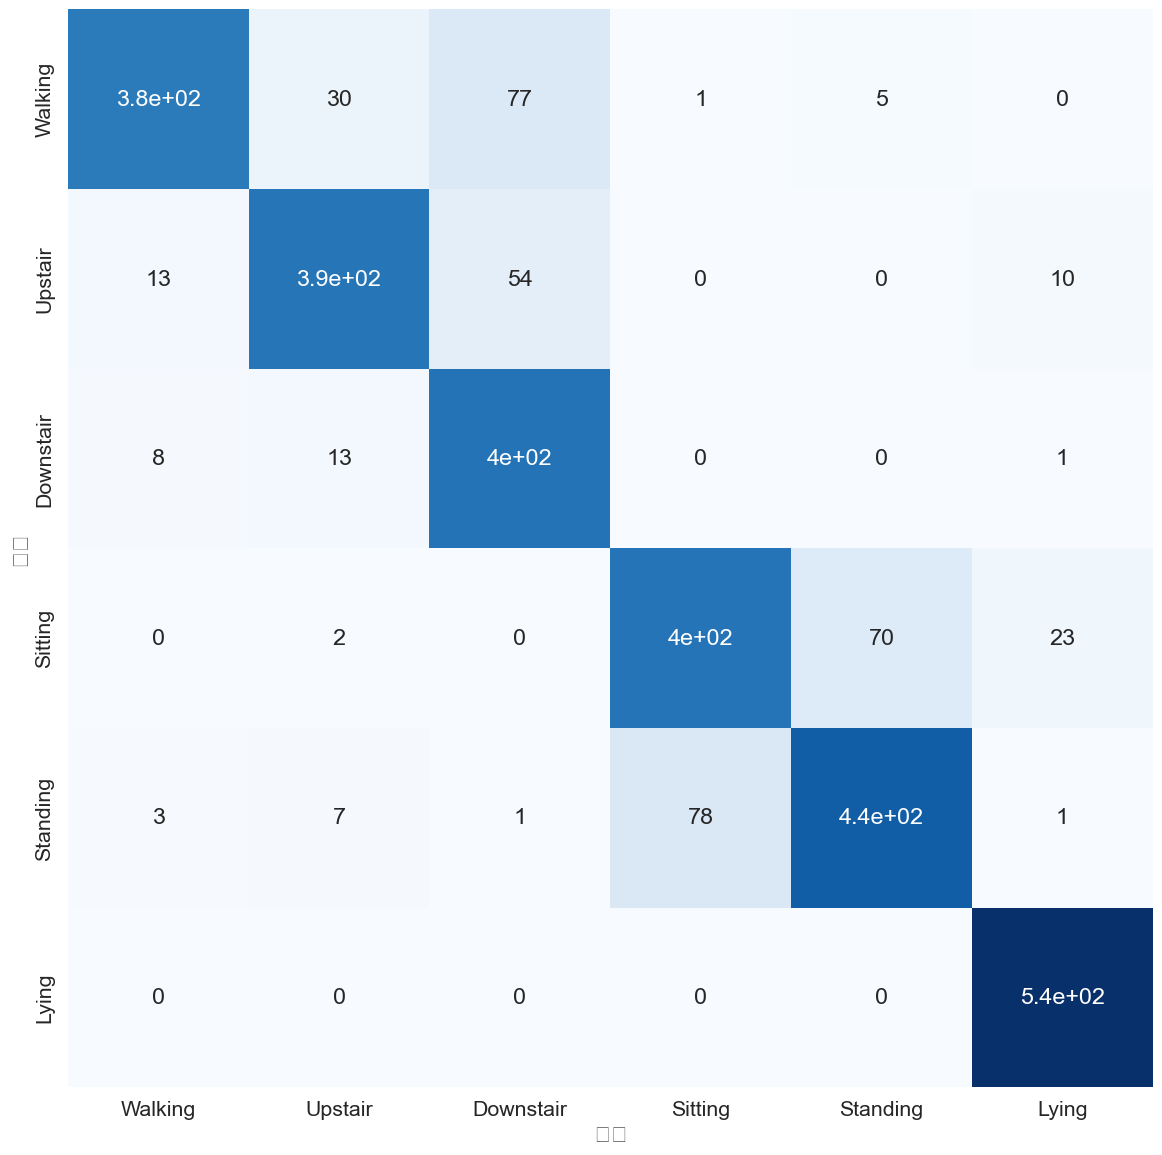

In [18]:
# 绘制混淆矩阵
results = confusion_matrix(all_targets, all_preds)
df_cm = pd.DataFrame(results, index=[i for i in ACTIVITY_LABEL],
                  columns=[i for i in ACTIVITY_LABEL])
plt.figure(figsize=(14, 14))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, cbar=False)
plt.ylabel('预测')
plt.xlabel('真实')
plt.savefig(filepath + 'HeatMap.png')
plt.show()

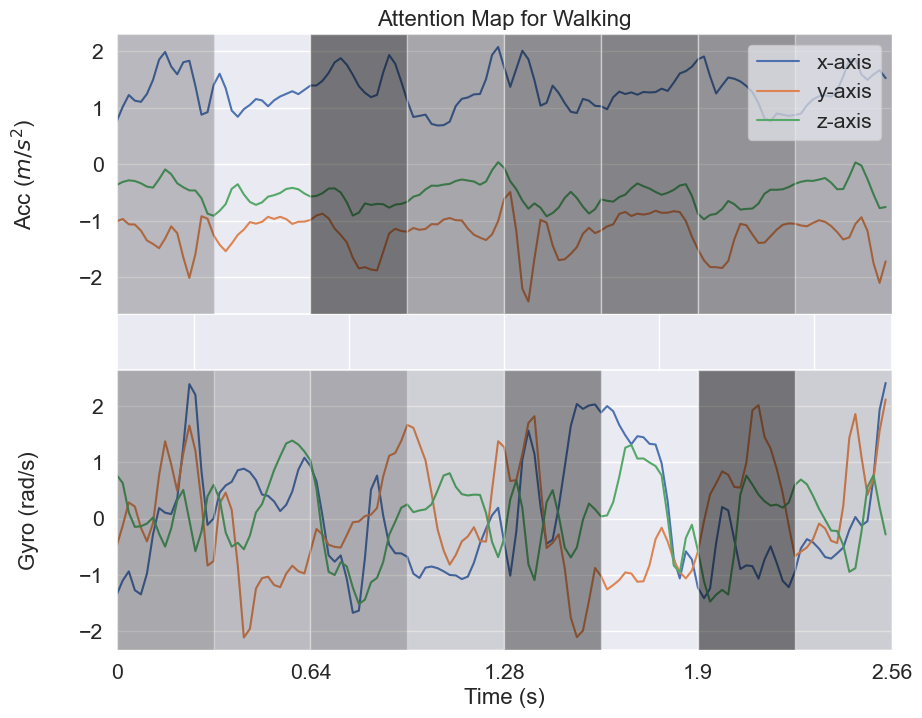

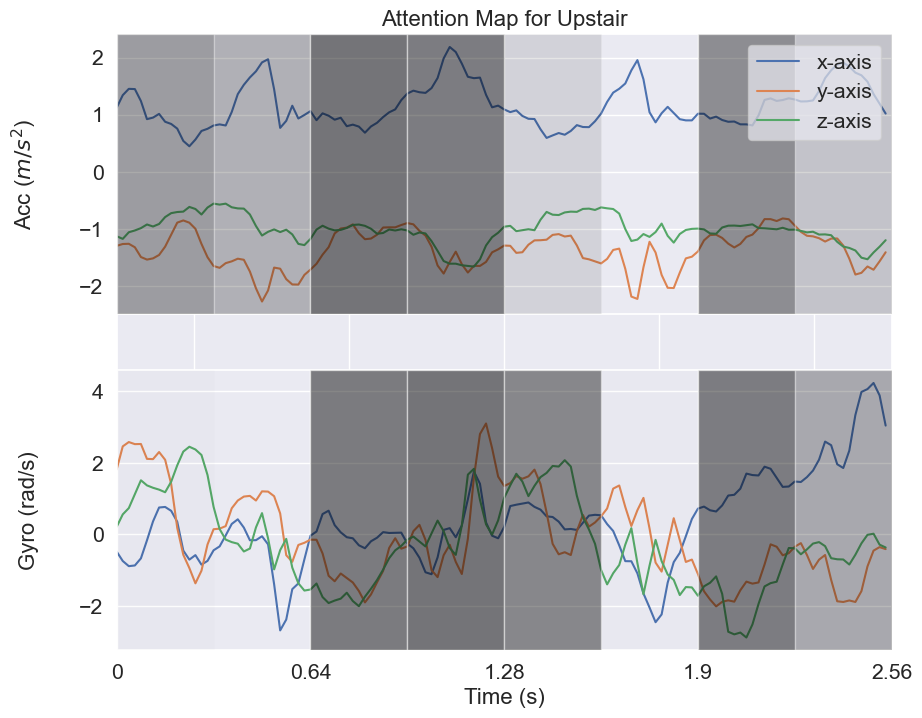

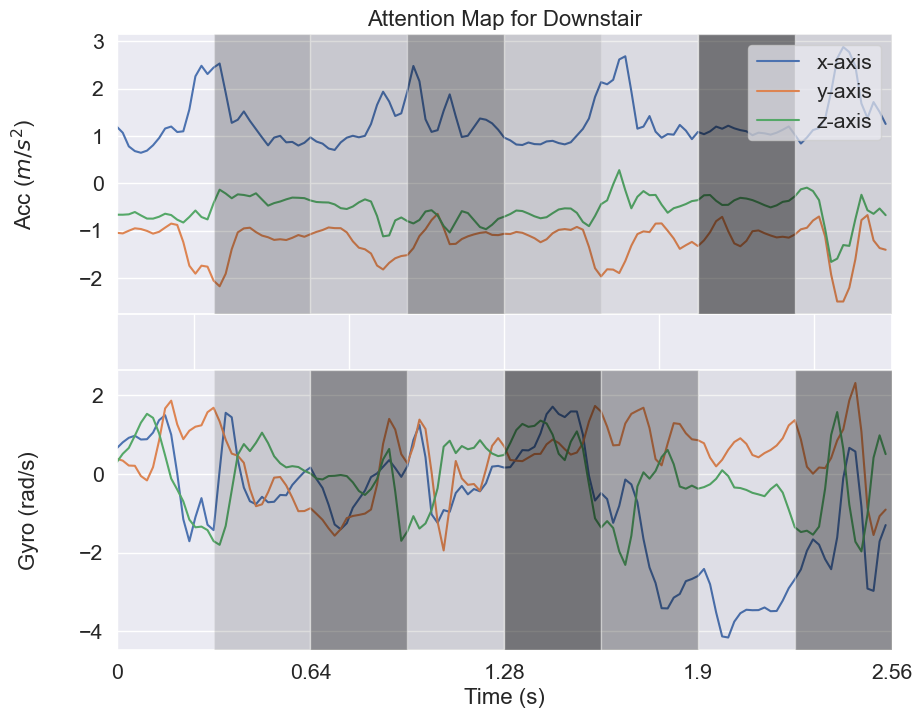

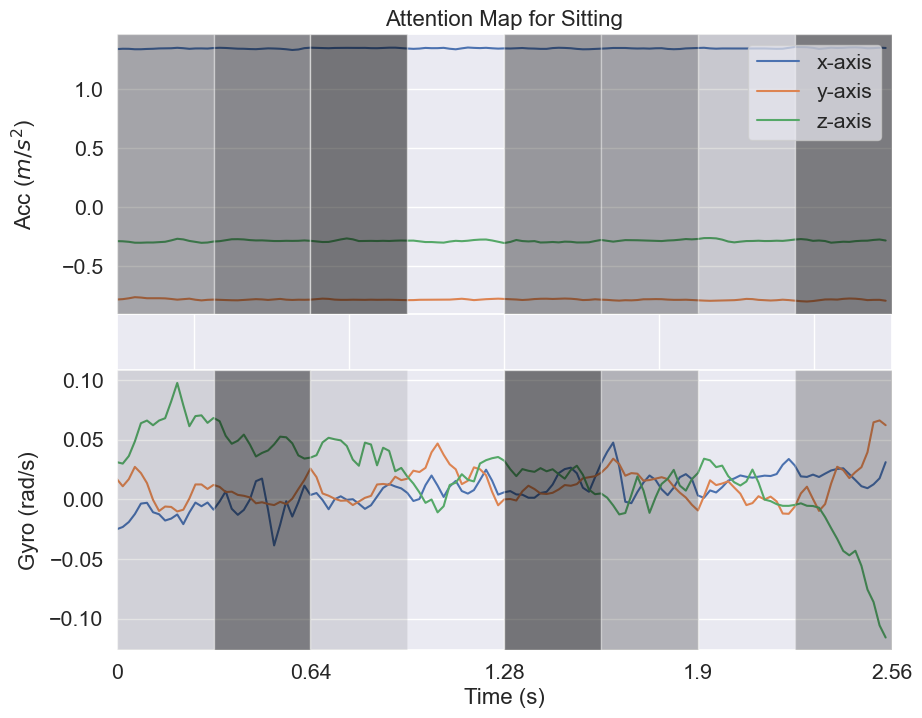

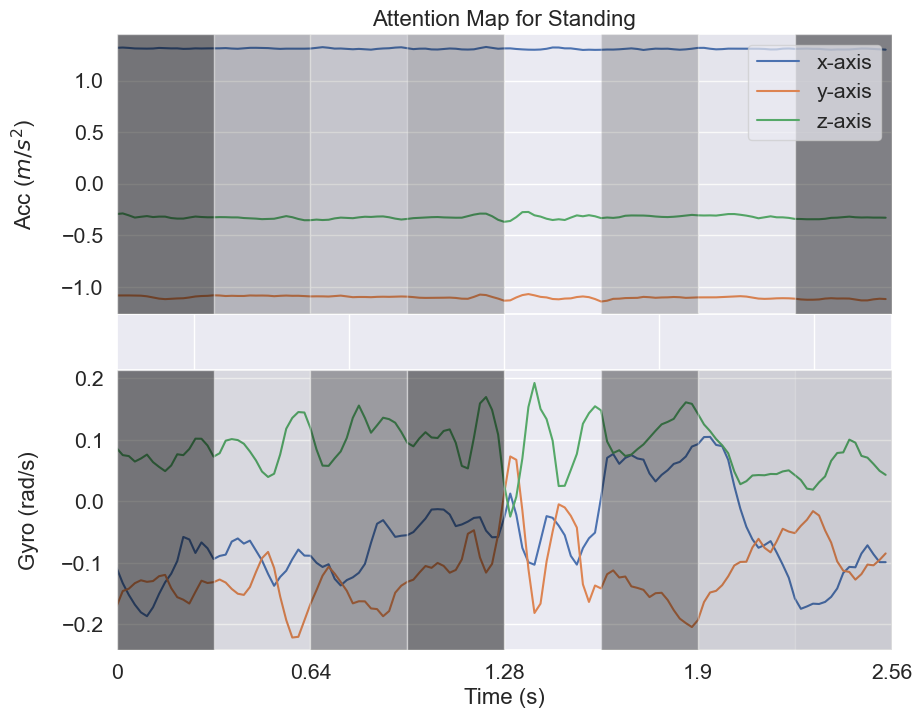

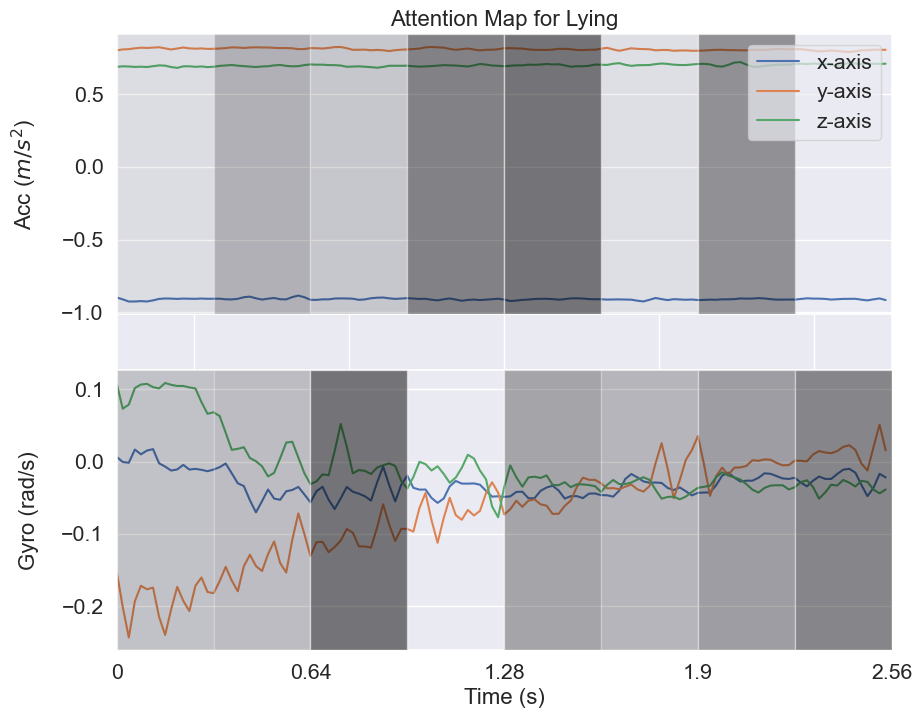

In [19]:
# 获取模型中的关键层
if architecture == "HART":
    final_acc_mha_name = get_layer_index_by_name(model_classifier, f"AccMHA_{len(conv_kernels)-1}")
    final_gyro_mha_name = get_layer_index_by_name(model_classifier, f"GyroMHA_{len(conv_kernels)-1}")
    final_inputs_name = get_layer_index_by_name(model_classifier, f"normalizedInputs_{len(conv_kernels)-1}")
    
    # 创建hook函数获取中间输出
    intermediate_outputs = {}
    def get_activation(name):
        def hook(model, input, output):
            intermediate_outputs[name] = output
        return hook
    
    # 注册钩子
    for name, module in model_classifier.named_modules():
        if name == final_inputs_name:
            module.register_forward_hook(get_activation(final_inputs_name))
            
    # 选择一些样本用于可视化
    indices = []
    for label in range(activity_count):
        label_indices = np.where(np.array(all_targets) == label)[0]
        if len(label_indices) > 0:
            indices.append(label_indices[2] if len(label_indices) > 2 else label_indices[0])
    
    segment_time = [x for x in range(0, segment_size - frame_length + time_step, time_step)]
    
    # 可视化注意力
    for index, class_loc in enumerate(indices):
        # 获取样本
        sample = test_features[class_loc].unsqueeze(0).to(device)
        
        # 清空中间输出
        intermediate_outputs.clear()
        
        # 前向传播
        with torch.no_grad():
            model_classifier(sample)
            
        # 注意：这里我们模拟注意力可视化
        # 实际上需要从模型中提取注意力权重
        # 由于PyTorch版本的模型结构不同，这里仅为示例
        
        # 生成伪注意力分数
        attention_scores = np.random.rand(len(segment_time))
        attention_scores_norm = ((attention_scores - min(attention_scores))/(max(attention_scores) - min(attention_scores)) -1) * - 0.5
        
        # 绘制第一组图（加速度计数据）
        gs = gridspec.GridSpec(2, 1)
        fig = plt.figure(figsize=(10, 8))
        plt.title(f"Attention Map for {ACTIVITY_LABEL[index]}", size=16)
        plt.margins(x=0)
        plt.tick_params(
        axis='both',
        which='both',
        labelleft=False,
        left=False,
        bottom=False,
        top=False,
        labelbottom=False)
        
        # 加速度计数据
        ax = fig.add_subplot(gs[0])
        ax.margins(x=0)
        
        sample_np = sample.cpu().numpy()[0]
        ax.plot(sample_np[:, 0], label="x-axis")
        ax.plot(sample_np[:, 1], label="y-axis")
        ax.plot(sample_np[:, 2], label="z-axis")
        
        for bar_index, start_time in enumerate(segment_time):
            ax.axvspan(start_time, start_time + frame_length, facecolor='black', alpha=float(attention_scores_norm[bar_index]), zorder=4)
        
        ax.set_ylabel(r'Acc ($m/s^2$)', size=16)
        ax.get_yaxis().set_label_coords(-0.1, 0.5)
        ax.tick_params(axis='x', labelbottom=False)
        plt.legend(loc='upper right', framealpha=0.7)
        
        # 生成第二组伪注意力分数
        attention_scores = np.random.rand(len(segment_time))
        attention_scores_norm = ((attention_scores - min(attention_scores))/(max(attention_scores) - min(attention_scores)) -1) * - 0.5
        
        # 陀螺仪数据
        ax = fig.add_subplot(gs[1], sharex=ax)
        ax.margins(x=0)
        
        ax.plot(sample_np[:, 3], label="x-axis")
        ax.plot(sample_np[:, 4], label="y-axis")
        ax.plot(sample_np[:, 5], label="z-axis")
        
        for bar_index, start_time in enumerate(segment_time):
            ax.axvspan(start_time, start_time + frame_length, facecolor='black', alpha=float(attention_scores_norm[bar_index]), zorder=99)
        
        ax.set_ylabel(r'Gyro (rad/s)', size=16)
        ax.get_yaxis().set_label_coords(-0.1, 0.5)
        plt.xticks([0, 32, 64, 96, 128])
        if len(fig.get_axes()) > 1:
            fig.get_axes()[1].set_xticklabels([0, 0.64, 1.28, 1.9, 2.56])
        plt.xlabel("Time (s)", size=16)
        plt.margins(x=0)
        
        plt.savefig(attention_path + ACTIVITY_LABEL[index] + "MeanHeadAttention.png", bbox_inches="tight")
        plt.show()
        plt.close()

## 学习曲线和模型导出

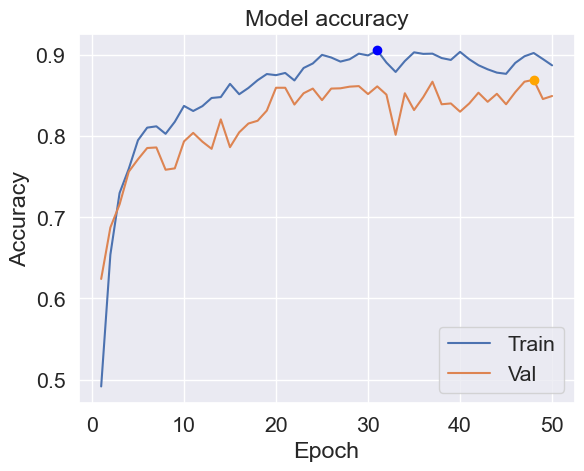

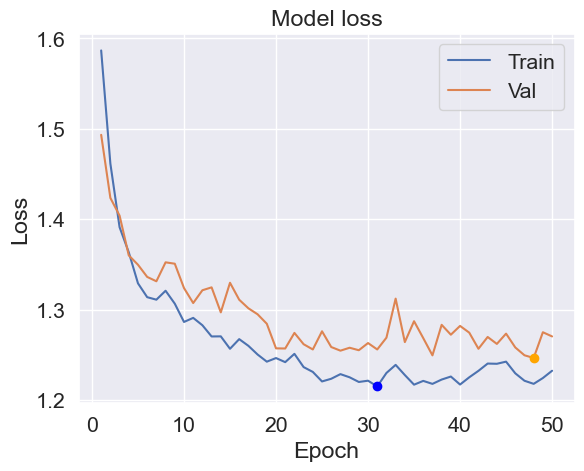

<Figure size 640x480 with 0 Axes>

In [20]:
# 绘制学习曲线
utils.plot_learning_curve(history, local_epoch, filepath)

In [ ]:
# 导出ONNX模型
# TODO:模型导出有bug
dummy_input = torch.randn(1, segment_size, num_input_channels, device=device)
torch.onnx.export(
    model_classifier,
    dummy_input,
    filepath + architecture + '.onnx',
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print("模型已导出为ONNX格式")

Torch IR graph at exception: graph(%0 : Float(*, 128, 6, strides=[768, 6, 1], requires_grad=0, device=cpu),
      %patches.acc_projection.weight : Float(96, 3, 16, strides=[48, 16, 1], requires_grad=1, device=cpu),
      %patches.acc_projection.bias : Float(96, strides=[1], requires_grad=1, device=cpu),
      %patches.gyro_projection.weight : Float(96, 3, 16, strides=[48, 16, 1], requires_grad=1, device=cpu),
      %patches.gyro_projection.bias : Float(96, strides=[1], requires_grad=1, device=cpu),
      %patch_encoder.position_embedding.weight : Float(8, 192, strides=[192, 1], requires_grad=1, device=cpu),
      %transformer_blocks.0.weight : Float(192, strides=[1], requires_grad=1, device=cpu),
      %transformer_blocks.0.bias : Float(192, strides=[1], requires_grad=1, device=cpu),
      %transformer_blocks.1.depthwise_kernels.0 : Float(1, 1, 3, strides=[3, 3, 1], requires_grad=1, device=cpu),
      %transformer_blocks.1.depthwise_kernels.1 : Float(1, 1, 3, strides=[3, 3, 1], require

SymbolicValueError: Unsupported: ONNX export of convolution for kernel of unknown shape.  [Caused by the value '183 defined in (%183 : Float(*, *, *, strides=[96, 1, 192], requires_grad=1, device=cpu) = onnx::Gather[axis=1](%182, %112), scope: model_pytorch.HART::/model_pytorch.LiteFormer::transformer_blocks.36 # /Users/zilongzeng/Research/MazeruHAR/model_pytorch.py:205:0
)' (type 'Tensor') in the TorchScript graph. The containing node has kind 'onnx::Gather'.] 
    (node defined in /Users/zilongzeng/Research/MazeruHAR/model_pytorch.py(205): forward
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1729): _slow_forward
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1750): _call_impl
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/Users/zilongzeng/Research/MazeruHAR/model_pytorch.py(491): forward
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1729): _slow_forward
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1750): _call_impl
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/jit/_trace.py(129): wrapper
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/jit/_trace.py(138): forward
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1750): _call_impl
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/jit/_trace.py(1498): _get_trace_graph
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/onnx/utils.py(844): _trace_and_get_graph_from_model
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/onnx/utils.py(937): _create_jit_graph
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/onnx/utils.py(1053): _model_to_graph
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/onnx/utils.py(1428): _export
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/onnx/utils.py(495): export
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/torch/onnx/__init__.py(383): export
/var/folders/fr/14dg9d1n4vx9sqmyh_9pqm3h0000gn/T/ipykernel_31489/2724334322.py(3): <module>
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3526): run_code
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3466): run_ast_nodes
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3284): run_cell_async
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3079): _run_cell
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3024): run_cell
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/zmqshell.py(549): run_cell
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/ipkernel.py(449): do_execute
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/kernelbase.py(778): execute_request
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/ipkernel.py(362): execute_request
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/kernelbase.py(534): process_one
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
/opt/anaconda3/envs/HAR/lib/python3.9/asyncio/events.py(80): _run
/opt/anaconda3/envs/HAR/lib/python3.9/asyncio/base_events.py(1905): _run_once
/opt/anaconda3/envs/HAR/lib/python3.9/asyncio/base_events.py(601): run_forever
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/tornado/platform/asyncio.py(205): start
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel/kernelapp.py(739): start
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/traitlets/config/application.py(1075): launch_instance
/opt/anaconda3/envs/HAR/lib/python3.9/site-packages/ipykernel_launcher.py(18): <module>
/opt/anaconda3/envs/HAR/lib/python3.9/runpy.py(87): _run_code
/opt/anaconda3/envs/HAR/lib/python3.9/runpy.py(197): _run_module_as_main
)

    Inputs:
        #0: 182 defined in (%182 : Float(*, *, *, *, strides=[96, 24, 1, 192], requires_grad=1, device=cpu) = onnx::Reshape(%175, %181), scope: model_pytorch.HART::/model_pytorch.LiteFormer::transformer_blocks.36 # /Users/zilongzeng/Research/MazeruHAR/model_pytorch.py:195:0
    )  (type 'Tensor')
        #1: 112 defined in (%112 : Long(device=cpu) = onnx::Constant[value={3}](), scope: model_pytorch.HART::/model_pytorch.SensorPatches::patches
    )  (type 'Tensor')
    Outputs:
        #0: 183 defined in (%183 : Float(*, *, *, strides=[96, 1, 192], requires_grad=1, device=cpu) = onnx::Gather[axis=1](%182, %112), scope: model_pytorch.HART::/model_pytorch.LiteFormer::transformer_blocks.36 # /Users/zilongzeng/Research/MazeruHAR/model_pytorch.py:205:0
    )  (type 'Tensor')

In [ ]:
# 显示模型性能统计
print(f"训练准确率: {max(history['train_accuracy']) * 100:.2f}%")
print(f"验证准确率: {max(history['val_accuracy']) * 100:.2f}%")
print(f"测试准确率: {test_acc * 100:.2f}%")
print(f"测试加权F1分数: {weight_val_f1:.4f}")
print(f"测试微平均F1分数: {micro_val_f1:.4f}")
print(f"测试宏平均F1分数: {macro_val_f1:.4f}")
print("训练完成!")